In [132]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

sns.set(style="white")

In [133]:
# reading the merged file. 

df =pd.read_csv("/Users/jj/PycharmProjects/little_ds_problem/src/merged.vcf", sep="\t", index_col=0)

In [134]:
# dropping duplicated rows after merging.
df = df.drop_duplicates()

# Looking at the heat map, T_QQ, ti_NS and ti_HS is None and FILTER is always PASS. 
# tf_GT == 


df = df.drop(["ti_NS", 'ti_HS', 'T_QQ', 'FILTER', 'tf_GT', 'T_GT', 'Q_GT'], axis=1)


# Q_BD is our Target.  Looking at this, there is only two option.  FP or TP. 
# I will make another column called target FP = 0 or FALSE, TP = 1 or TRUE.

def get_target(row):
    if row.Q_BD == 'FP':
        return 0
    elif row.Q_BD == 'TP':
        return 1 
   

df["target"] = df.apply(get_target, axis=1)

In [135]:
# Convert categorical values into continuous variables. 
# This is very painful part when you have 76 columns 

df

,CHROM,POS,REF,ALT,QUAL,tf_GQ,tf_DP,tf_RO,tf_AO,tf_SRF,...,T_BK,T_BLT,T_BVT,Q_BD,Q_BI,Q_BK,Q_BLT,Q_BVT,Q_QQ,target
0,1,871334,G,T,496.5430,332.0,192.0,87.0,105.0,48.0,...,NaN,nocall,NOCALL,FP,tv,NaN,het,SNP,496.5430,0
1,1,876499,A,G,2585.0000,122.0,271.0,0.0,222.0,0.0,...,NaN,nocall,NOCALL,FP,ti,NaN,homalt,SNP,2585.0000,0
2,1,877715,C,G,366.7000,8.0,44.0,2.0,42.0,2.0,...,gm,homalt,SNP,TP,tv,gm,homalt,SNP,366.7000,1
4,1,878314,G,C,306.1140,15.0,33.0,0.0,33.0,0.0,...,gm,homalt,SNP,TP,tv,gm,homalt,SNP,306.1140,1
5,1,880238,A,G,904.5430,43.0,95.0,0.0,95.0,0.0,...,gm,homalt,SNP,TP,ti,gm,homalt,SNP,904.5430,1
6,1,881627,G,A,2620.1800,115.0,282.0,1.0,276.0,1.0,...,gm,homalt,SNP,TP,ti,gm,homalt,SNP,2620.1800,1
7,1,883625,A,G,577.4400,27.0,57.0,0.0,57.0,0.0,...,NaN,nocall,NOCALL,FP,ti,NaN,homalt,SNP,577.4400,0
8,1,887560,A,C,2091.2500,90.0,218.0,1.0,217.0,1.0,...,gm,homalt,SNP,TP,tv,gm,homalt,SNP,2091.2500,1
9,1,887801,A,G,867.0580,41.0,89.0,0.0,89.0,0.0,...,gm,homalt,SNP,TP,ti,gm,homalt,SNP,867.0580,1
11,1,888639,T,C,877.1220,34.0,90.0,1.0,89.0,0.0,...,gm,homalt,SNP,TP,ti,gm,homalt,SNP,877.1220,1


In [141]:
# Look at the correlation matrix and figure out which fields are not important. 
# keep tf_GQ
# drop 'tf_DP', 'tf_RO', 'tf_SRF', 'tf_SRR'

# df = df.drop(['tf_DP', 'ti_DP', 'tf_RO', 'tf_SRF', 'tf_SRR'], axis=1)


corr_matrix = df.corr()

high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y] 

high_corr_var







# df[["tf_GQ",'tf_FSRF']]

[('QUAL', 'Q_QQ'),
 ('tf_GQ', 'tf_FRO'),
 ('tf_GQ', 'tf_FSRF'),
 ('tf_GQ', 'tf_FSRR'),
 ('tf_GQ', 'ti_FRO'),
 ('tf_GQ', 'ti_FSRF'),
 ('tf_GQ', 'ti_FSRR'),
 ('tf_FDP', 'ti_FDP'),
 ('tf_FRO', 'tf_FSRF'),
 ('tf_FRO', 'tf_FSRR'),
 ('tf_FRO', 'ti_RO'),
 ('tf_FRO', 'ti_SRF'),
 ('tf_FRO', 'ti_SRR'),
 ('tf_FRO', 'ti_FRO'),
 ('tf_FRO', 'ti_FSRF'),
 ('tf_FRO', 'ti_FSRR'),
 ('tf_FSRF', 'tf_FSRR'),
 ('tf_FSRF', 'ti_RO'),
 ('tf_FSRF', 'ti_SRF'),
 ('tf_FSRF', 'ti_FRO'),
 ('tf_FSRF', 'ti_FSRF'),
 ('tf_FSRF', 'ti_FSRR'),
 ('tf_FSRR', 'ti_RO'),
 ('tf_FSRR', 'ti_SRR'),
 ('tf_FSRR', 'ti_FRO'),
 ('tf_FSRR', 'ti_FSRF'),
 ('tf_FSRR', 'ti_FSRR'),
 ('ti_RO', 'ti_SRF'),
 ('ti_RO', 'ti_SRR'),
 ('ti_RO', 'ti_FRO'),
 ('ti_RO', 'ti_FSRF'),
 ('ti_RO', 'ti_FSRR'),
 ('ti_SRF', 'ti_SRR'),
 ('ti_SRF', 'ti_FRO'),
 ('ti_SRF', 'ti_FSRF'),
 ('ti_SRR', 'ti_FRO'),
 ('ti_SRR', 'ti_FSRR'),
 ('ti_FRO', 'ti_FSRF'),
 ('ti_FRO', 'ti_FSRR'),
 ('ti_FSRF', 'ti_FSRR')]

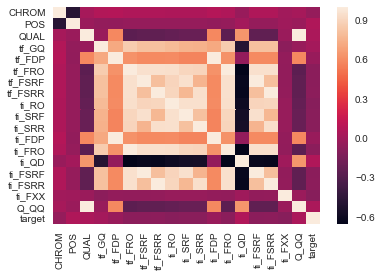

In [142]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [44]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d"
      % (iris.data.shape[0],(iris.target != y_pred).sum()))

iris.target

Number of mislabeled points out of a total 150 points : 6


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])